In [4]:
%%capture
!pip install -U git+https://github.com/qubvel-org/segmentation_models.pytorch
!pip install lightning albumentations

In [5]:
import os

import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader

Most models in this library require a height and width that is divisible by 32. So let's check the height. 

In [21]:
from PIL import Image
import os

# Define the path to the dataset
IMAGE_DIR = '/kaggle/input/huron-dataset/Sliced_Images'

# Get the first image filename (you can loop over all files if needed)
first_image_filename = os.listdir(IMAGE_DIR)[0]
first_image_path = os.path.join(IMAGE_DIR, first_image_filename)

# Open the image using PIL
image = Image.open(first_image_path)

# Get the dimensions (height, width)
width, height = image.size

# Print the image dimensions
print(f"Width: {width}, Height: {height}")


Width: 512, Height: 512


In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_filenames, mask_filenames, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Load the image and the corresponding mask
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Binary mask: use "L" mode

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return {"image": image, "mask": mask}


# Define paths to the dataset
IMAGE_DIR = '/kaggle/input/huron-dataset/Sliced_Images'
MASK_DIR = '/kaggle/input/huron-dataset/Sliced_masks'

# Get the filenames for images and masks
image_filenames = sorted(os.listdir(IMAGE_DIR))
mask_filenames = sorted(os.listdir(MASK_DIR))

# Split dataset (e.g., 80% train, 10% validation, 10% test)
train_filenames, temp_filenames = train_test_split(image_filenames, test_size=0.2, random_state=42)
val_filenames, test_filenames = train_test_split(temp_filenames, test_size=0.5, random_state=42)

# Ensure that masks are matched correctly to images in the splits
train_mask_filenames = [filename for filename in train_filenames]
val_mask_filenames = [filename for filename in val_filenames]
test_mask_filenames = [filename for filename in test_filenames]

# Define transformations (if any)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create subsets for train, validation, and test datasets
train_dataset = CustomDataset(IMAGE_DIR, MASK_DIR, train_filenames, train_mask_filenames, transform=transform)
val_dataset = CustomDataset(IMAGE_DIR, MASK_DIR, val_filenames, val_mask_filenames, transform=transform)
test_dataset = CustomDataset(IMAGE_DIR, MASK_DIR, test_filenames, test_mask_filenames, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# Print the dataset sizes
print(f"Training set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

examples = next(iter(train_loader))

print(examples["image"].shape)
print(examples["mask"].shape)


Training set size: 13877
Validation set size: 1735
Test set size: 1735
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])


<class 'torch.Tensor'>


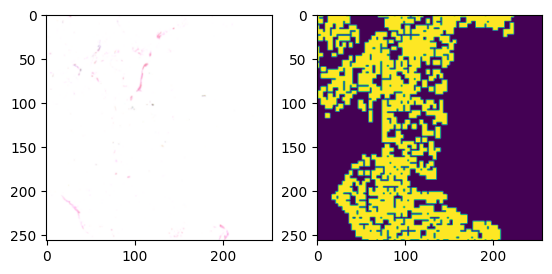

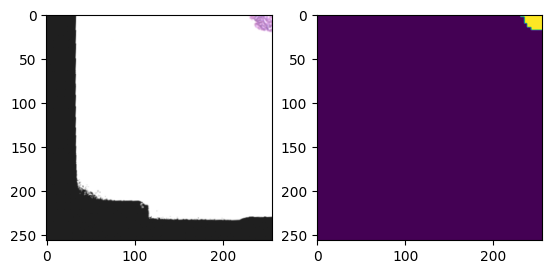

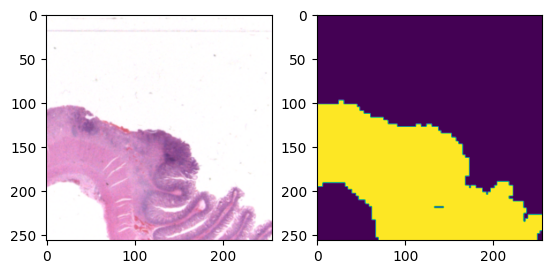

In [14]:
# lets look at some samples

sample = train_dataset[0]

print(type(sample["image"]))

plt.subplot(1, 2, 1)
# for visualization we have to transpose back to HWC
plt.imshow(sample["image"].permute(1, 2, 0))
plt.subplot(1, 2, 2)
# for visualization we have to remove 3rd dimension of mask
plt.imshow(sample["mask"].squeeze())
plt.show()

sample = val_dataset[0]
plt.subplot(1, 2, 1)
# for visualization we have to transpose back to HWC
plt.imshow(sample["image"].permute(1, 2, 0))
plt.subplot(1, 2, 2)
# for visualization we have to remove 3rd dimension of mask
plt.imshow(sample["mask"].squeeze())
plt.show()

sample = test_dataset[0]
plt.subplot(1, 2, 1)
# for visualization we have to transpose back to HWC
plt.imshow(sample["image"].permute(1, 2, 0))
plt.subplot(1, 2, 2)
# for visualization we have to remove 3rd dimension of mask
plt.imshow(sample["mask"].squeeze())
plt.show()

In [48]:
class PetModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # normalize image here
        image = (image - self.mean.to(device)) / self.std.to(device)
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch["image"].to(device)

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"].to(device)
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }
        return

In [49]:
import segmentation_models_pytorch as smp
import torch
import pytorch_lightning as pl

# Set model parameters
arch = "unet"  # Choose model architecture, e.g., "unet"
encoder_name = "resnet34"  # Choose encoder, e.g., "resnet34", "efficientnet-b0"
in_channels = 3  # For RGB images
out_classes = 1  # For binary segmentation

# Initialize the model
model = PetModel(
    arch=arch,
    encoder_name=encoder_name,
    in_channels=in_channels,
    out_classes=out_classes,
)


In [42]:
# Some training hyperparameters
EPOCHS = 10
T_MAX = EPOCHS * len(train_loader)
OUT_CLASSES = 1

In [51]:
# Check for one batch from the train loader
sample = next(iter(train_loader))
image = sample['image'].to(device)
mask = sample['mask'].to(device)

model.to(device)

# Forward pass through the model
output = model(image)
print(output.shape)


torch.Size([64, 1, 256, 256])


In [55]:
from pytorch_lightning.callbacks import Callback
import torch

class DebugCallback(Callback):
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        # This will print the memory usage after every batch
        print(f"Batch {batch_idx} finished")
        print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1024 ** 2} MB")
        print(f"Memory Cached: {torch.cuda.memory_reserved() / 1024 ** 2} MB")

# Add this callback to the Trainer
debug_callback = DebugCallback()

trainer = pl.Trainer(
    accelerator="gpu", 
    max_epochs=EPOCHS, 
    log_every_n_steps=1,
    callbacks=[debug_callback]  # Add your custom callback
)

trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Batch 0 finished
Memory Allocated: 6696.58203125 MB
Memory Cached: 13500.0 MB
Batch 1 finished
Memory Allocated: 6696.83447265625 MB
Memory Cached: 14114.0 MB
Batch 2 finished
Memory Allocated: 6696.3369140625 MB
Memory Cached: 14114.0 MB
Batch 3 finished
Memory Allocated: 6695.83935546875 MB
Memory Cached: 14114.0 MB
Batch 4 finished
Memory Allocated: 6696.091796875 MB
Memory Cached: 14114.0 MB
Batch 5 finished
Memory Allocated: 6696.84423828125 MB
Memory Cached: 14114.0 MB
Batch 6 finished
Memory Allocated: 6696.0966796875 MB
Memory Cached: 14114.0 MB
Batch 7 finished
Memory Allocated: 6696.84912109375 MB
Memory Cached: 14114.0 MB
Batch 8 finished
Memory Allocated: 6696.1015625 MB
Memory Cached: 14114.0 MB
Batch 9 finished
Memory Allocated: 6696.85400390625 MB
Memory Cached: 14114.0 MB
Batch 10 finished
Memory Allocated: 6696.1064453125 MB
Memory Cached: 14114.0 MB
Batch 11 finished
Memory Allocated: 6696.85888671875 MB
Memory Cached: 14114.0 MB
Batch 12 finished
Memory Allocated: 66

Validation: |          | 0/? [00:00<?, ?it/s]

Batch 0 finished
Memory Allocated: 6695.92529296875 MB
Memory Cached: 14116.0 MB
Batch 1 finished
Memory Allocated: 6695.927734375 MB
Memory Cached: 14116.0 MB
Batch 2 finished
Memory Allocated: 6695.18017578125 MB
Memory Cached: 14116.0 MB
Batch 3 finished
Memory Allocated: 6695.1826171875 MB
Memory Cached: 14116.0 MB
Batch 4 finished
Memory Allocated: 6695.68505859375 MB
Memory Cached: 14116.0 MB
Batch 5 finished
Memory Allocated: 6695.9375 MB
Memory Cached: 14116.0 MB
Batch 6 finished
Memory Allocated: 6696.43994140625 MB
Memory Cached: 14116.0 MB
Batch 7 finished
Memory Allocated: 6695.6923828125 MB
Memory Cached: 14116.0 MB
Batch 8 finished
Memory Allocated: 6696.44482421875 MB
Memory Cached: 14116.0 MB
Batch 9 finished
Memory Allocated: 6695.697265625 MB
Memory Cached: 14116.0 MB
Batch 10 finished
Memory Allocated: 6696.44970703125 MB
Memory Cached: 14116.0 MB
Batch 11 finished
Memory Allocated: 6695.7021484375 MB
Memory Cached: 14116.0 MB
Batch 12 finished
Memory Allocated: 6696

Validation: |          | 0/? [00:00<?, ?it/s]

Batch 0 finished
Memory Allocated: 6695.92529296875 MB
Memory Cached: 14116.0 MB
Batch 1 finished
Memory Allocated: 6695.927734375 MB
Memory Cached: 14116.0 MB
Batch 2 finished
Memory Allocated: 6695.18017578125 MB
Memory Cached: 14116.0 MB
Batch 3 finished
Memory Allocated: 6695.1826171875 MB
Memory Cached: 14116.0 MB
Batch 4 finished
Memory Allocated: 6695.68505859375 MB
Memory Cached: 14116.0 MB
Batch 5 finished
Memory Allocated: 6695.9375 MB
Memory Cached: 14116.0 MB
Batch 6 finished
Memory Allocated: 6696.43994140625 MB
Memory Cached: 14116.0 MB
Batch 7 finished
Memory Allocated: 6695.6923828125 MB
Memory Cached: 14116.0 MB
Batch 8 finished
Memory Allocated: 6696.44482421875 MB
Memory Cached: 14116.0 MB
Batch 9 finished
Memory Allocated: 6695.697265625 MB
Memory Cached: 14116.0 MB
Batch 10 finished
Memory Allocated: 6696.44970703125 MB
Memory Cached: 14116.0 MB
Batch 11 finished
Memory Allocated: 6695.7021484375 MB
Memory Cached: 14116.0 MB
Batch 12 finished
Memory Allocated: 6696

Validation: |          | 0/? [00:00<?, ?it/s]

Batch 0 finished
Memory Allocated: 6695.92529296875 MB
Memory Cached: 14116.0 MB
Batch 1 finished
Memory Allocated: 6695.927734375 MB
Memory Cached: 14116.0 MB
Batch 2 finished
Memory Allocated: 6695.18017578125 MB
Memory Cached: 14116.0 MB
Batch 3 finished
Memory Allocated: 6695.1826171875 MB
Memory Cached: 14116.0 MB
Batch 4 finished
Memory Allocated: 6695.68505859375 MB
Memory Cached: 14116.0 MB
Batch 5 finished
Memory Allocated: 6695.9375 MB
Memory Cached: 14116.0 MB
Batch 6 finished
Memory Allocated: 6696.43994140625 MB
Memory Cached: 14116.0 MB
Batch 7 finished
Memory Allocated: 6695.6923828125 MB
Memory Cached: 14116.0 MB
Batch 8 finished
Memory Allocated: 6696.44482421875 MB
Memory Cached: 14116.0 MB
Batch 9 finished
Memory Allocated: 6695.697265625 MB
Memory Cached: 14116.0 MB
Batch 10 finished
Memory Allocated: 6696.44970703125 MB
Memory Cached: 14116.0 MB
Batch 11 finished
Memory Allocated: 6695.7021484375 MB
Memory Cached: 14116.0 MB
Batch 12 finished
Memory Allocated: 6696

Validation: |          | 0/? [00:00<?, ?it/s]

Batch 0 finished
Memory Allocated: 6695.92529296875 MB
Memory Cached: 14116.0 MB
Batch 1 finished
Memory Allocated: 6695.927734375 MB
Memory Cached: 14116.0 MB
Batch 2 finished
Memory Allocated: 6695.18017578125 MB
Memory Cached: 14116.0 MB
Batch 3 finished
Memory Allocated: 6695.1826171875 MB
Memory Cached: 14116.0 MB
Batch 4 finished
Memory Allocated: 6695.68505859375 MB
Memory Cached: 14116.0 MB
Batch 5 finished
Memory Allocated: 6695.9375 MB
Memory Cached: 14116.0 MB
Batch 6 finished
Memory Allocated: 6696.43994140625 MB
Memory Cached: 14116.0 MB
Batch 7 finished
Memory Allocated: 6695.6923828125 MB
Memory Cached: 14116.0 MB
Batch 8 finished
Memory Allocated: 6696.44482421875 MB
Memory Cached: 14116.0 MB
Batch 9 finished
Memory Allocated: 6695.697265625 MB
Memory Cached: 14116.0 MB
Batch 10 finished
Memory Allocated: 6696.44970703125 MB
Memory Cached: 14116.0 MB
Batch 11 finished
Memory Allocated: 6695.7021484375 MB
Memory Cached: 14116.0 MB
Batch 12 finished
Memory Allocated: 6696

Validation: |          | 0/? [00:00<?, ?it/s]

Batch 0 finished
Memory Allocated: 6695.92529296875 MB
Memory Cached: 14116.0 MB
Batch 1 finished
Memory Allocated: 6695.927734375 MB
Memory Cached: 14116.0 MB
Batch 2 finished
Memory Allocated: 6695.18017578125 MB
Memory Cached: 14116.0 MB
Batch 3 finished
Memory Allocated: 6695.1826171875 MB
Memory Cached: 14116.0 MB
Batch 4 finished
Memory Allocated: 6695.68505859375 MB
Memory Cached: 14116.0 MB
Batch 5 finished
Memory Allocated: 6695.9375 MB
Memory Cached: 14116.0 MB
Batch 6 finished
Memory Allocated: 6696.43994140625 MB
Memory Cached: 14116.0 MB
Batch 7 finished
Memory Allocated: 6695.6923828125 MB
Memory Cached: 14116.0 MB
Batch 8 finished
Memory Allocated: 6696.44482421875 MB
Memory Cached: 14116.0 MB
Batch 9 finished
Memory Allocated: 6695.697265625 MB
Memory Cached: 14116.0 MB
Batch 10 finished
Memory Allocated: 6696.44970703125 MB
Memory Cached: 14116.0 MB
Batch 11 finished
Memory Allocated: 6695.7021484375 MB
Memory Cached: 14116.0 MB
Batch 12 finished
Memory Allocated: 6696

Validation: |          | 0/? [00:00<?, ?it/s]

Batch 0 finished
Memory Allocated: 6695.92529296875 MB
Memory Cached: 14116.0 MB
Batch 1 finished
Memory Allocated: 6695.927734375 MB
Memory Cached: 14116.0 MB
Batch 2 finished
Memory Allocated: 6695.18017578125 MB
Memory Cached: 14116.0 MB
Batch 3 finished
Memory Allocated: 6695.1826171875 MB
Memory Cached: 14116.0 MB
Batch 4 finished
Memory Allocated: 6695.68505859375 MB
Memory Cached: 14116.0 MB
Batch 5 finished
Memory Allocated: 6695.9375 MB
Memory Cached: 14116.0 MB
Batch 6 finished
Memory Allocated: 6696.43994140625 MB
Memory Cached: 14116.0 MB
Batch 7 finished
Memory Allocated: 6695.6923828125 MB
Memory Cached: 14116.0 MB
Batch 8 finished
Memory Allocated: 6696.44482421875 MB
Memory Cached: 14116.0 MB
Batch 9 finished
Memory Allocated: 6695.697265625 MB
Memory Cached: 14116.0 MB
Batch 10 finished
Memory Allocated: 6696.44970703125 MB
Memory Cached: 14116.0 MB
Batch 11 finished
Memory Allocated: 6695.7021484375 MB
Memory Cached: 14116.0 MB
Batch 12 finished
Memory Allocated: 6696

Validation: |          | 0/? [00:00<?, ?it/s]

Batch 0 finished
Memory Allocated: 6695.92529296875 MB
Memory Cached: 14116.0 MB
Batch 1 finished
Memory Allocated: 6695.927734375 MB
Memory Cached: 14116.0 MB
Batch 2 finished
Memory Allocated: 6695.18017578125 MB
Memory Cached: 14116.0 MB
Batch 3 finished
Memory Allocated: 6695.1826171875 MB
Memory Cached: 14116.0 MB
Batch 4 finished
Memory Allocated: 6695.68505859375 MB
Memory Cached: 14116.0 MB
Batch 5 finished
Memory Allocated: 6695.9375 MB
Memory Cached: 14116.0 MB
Batch 6 finished
Memory Allocated: 6696.43994140625 MB
Memory Cached: 14116.0 MB
Batch 7 finished
Memory Allocated: 6695.6923828125 MB
Memory Cached: 14116.0 MB
Batch 8 finished
Memory Allocated: 6696.44482421875 MB
Memory Cached: 14116.0 MB
Batch 9 finished
Memory Allocated: 6695.697265625 MB
Memory Cached: 14116.0 MB
Batch 10 finished
Memory Allocated: 6696.44970703125 MB
Memory Cached: 14116.0 MB
Batch 11 finished
Memory Allocated: 6695.7021484375 MB
Memory Cached: 14116.0 MB
Batch 12 finished
Memory Allocated: 6696

Validation: |          | 0/? [00:00<?, ?it/s]

Batch 0 finished
Memory Allocated: 6695.92529296875 MB
Memory Cached: 14116.0 MB
Batch 1 finished
Memory Allocated: 6695.927734375 MB
Memory Cached: 14116.0 MB
Batch 2 finished
Memory Allocated: 6695.18017578125 MB
Memory Cached: 14116.0 MB
Batch 3 finished
Memory Allocated: 6695.1826171875 MB
Memory Cached: 14116.0 MB
Batch 4 finished
Memory Allocated: 6695.68505859375 MB
Memory Cached: 14116.0 MB
Batch 5 finished
Memory Allocated: 6695.9375 MB
Memory Cached: 14116.0 MB
Batch 6 finished
Memory Allocated: 6696.43994140625 MB
Memory Cached: 14116.0 MB
Batch 7 finished
Memory Allocated: 6695.6923828125 MB
Memory Cached: 14116.0 MB
Batch 8 finished
Memory Allocated: 6696.44482421875 MB
Memory Cached: 14116.0 MB
Batch 9 finished
Memory Allocated: 6695.697265625 MB
Memory Cached: 14116.0 MB
Batch 10 finished
Memory Allocated: 6696.44970703125 MB
Memory Cached: 14116.0 MB
Batch 11 finished
Memory Allocated: 6695.7021484375 MB
Memory Cached: 14116.0 MB
Batch 12 finished
Memory Allocated: 6696

Validation: |          | 0/? [00:00<?, ?it/s]

Batch 0 finished
Memory Allocated: 6695.92529296875 MB
Memory Cached: 14116.0 MB
Batch 1 finished
Memory Allocated: 6695.927734375 MB
Memory Cached: 14116.0 MB
Batch 2 finished
Memory Allocated: 6695.18017578125 MB
Memory Cached: 14116.0 MB
Batch 3 finished
Memory Allocated: 6695.1826171875 MB
Memory Cached: 14116.0 MB
Batch 4 finished
Memory Allocated: 6695.68505859375 MB
Memory Cached: 14116.0 MB
Batch 5 finished
Memory Allocated: 6695.9375 MB
Memory Cached: 14116.0 MB
Batch 6 finished
Memory Allocated: 6696.43994140625 MB
Memory Cached: 14116.0 MB
Batch 7 finished
Memory Allocated: 6695.6923828125 MB
Memory Cached: 14116.0 MB
Batch 8 finished
Memory Allocated: 6696.44482421875 MB
Memory Cached: 14116.0 MB
Batch 9 finished
Memory Allocated: 6695.697265625 MB
Memory Cached: 14116.0 MB
Batch 10 finished
Memory Allocated: 6696.44970703125 MB
Memory Cached: 14116.0 MB
Batch 11 finished
Memory Allocated: 6695.7021484375 MB
Memory Cached: 14116.0 MB
Batch 12 finished
Memory Allocated: 6696

Validation: |          | 0/? [00:00<?, ?it/s]

In [56]:
trainer.test(model, test_loader)


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_dataset_iou      │            0.0            │
│    test_per_image_iou     │    0.10662824660539627    │
└───────────────────────────┴───────────────────────────┘

[{'test_per_image_iou': 0.10662824660539627, 'test_dataset_iou': 0.0}]

In [19]:
print(f"Training data length: {len(train_dataset)}")
print(f"Validation data length: {len(val_dataset)}")


Training data length: 17347
Validation data length: 17347
